In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Load your CSV file
file_path = 'Green_Apple_Data_New.xlsx'
sheet = 'Green_Apple_Data'
df = pd.read_excel(io=file_path, sheet_name=sheet)

In [3]:
df.head()

,SNO,Date,STG1,STG2,STG3,STG4,STG5,STG6,A1,A2,A3,A4,A5,A6,GP1,GP2,GP3,GP4,GP5,GP6
0,1,1931-01-01,0.00,0.0,0.0,0.000000,0.0,0,1,0,1,1,1,1,0.000000,0.0,20.00,66.000000,100.0,0
1,2,2007-02-01,0.00,0.0,20.0,66.000000,100.0,0,1,0,0,0,1,1,0.000000,0.0,20.00,66.000000,57.0,83
2,3,2014-02-01,0.00,0.0,20.0,66.000000,57.0,83,1,0,1,1,0,0,50.000000,0.0,100.00,100.000000,57.0,83
3,4,2021-02-01,50.00,0.0,100.0,100.000000,57.0,83,1,0,0,1,0,0,93.750000,0.0,100.00,78.666667,57.0,83
4,5,2007-03-01,93.75,0.0,100.0,78.666667,57.0,83,1,0,1,0,0,0,79.666667,0.0,94.33,78.666667,57.0,83


In [4]:
X = df.iloc[:, 2:14].values
y = df.iloc[:, 14:].values

In [14]:
# print(y)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
# Standardize the input data
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)

# # Standardize the output data
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train)
# y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)


In [8]:
# Define the neural network with dropout
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(12, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.layer2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.layer3 = nn.Linear(32, 6)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.layer3(x)
        return x


In [9]:
# Instantiate the model, loss function, and optimizer
model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Lists to store training and test losses
train_losses = []
test_losses = []

# Variables for early stopping
best_test_loss = float('inf')
patience = 10  # Number of epochs to wait if no improvement is observed
counter = 0  # Counter for patience

# Training the model
num_epochs = 250
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Append training loss
    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = criterion(y_pred, y_test)
        test_losses.append(test_loss.item())

        # Check for early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in test loss.')
            break


Epoch [10/250], Loss: 1409.9960
Epoch [20/250], Loss: 1529.7797
Epoch [30/250], Loss: 2198.4788
Epoch [40/250], Loss: 1076.0574
Epoch [50/250], Loss: 1040.1931
Early stopping at epoch 56 due to no improvement in test loss.


In [10]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert the standardized predictions back to original scale
# y_pred_original = scaler_y.inverse_transform(y_pred.numpy())
# y_test_original = scaler_y.inverse_transform(y_test.numpy())

Test Loss: 805.5984


In [11]:
print(y_pred)

tensor([[45.1885, 64.6946, 39.9050, 40.5578, 16.3395, -2.7194],
        [39.5995, 53.0363, 33.3429, 32.9382, 14.9543,  0.5979],
        [76.6061, 16.2209, 76.9088, 77.2049, 64.4552, 62.5800],
        [50.9002, 52.7365, 52.2839, 56.3924, 34.8114, 12.4169]])


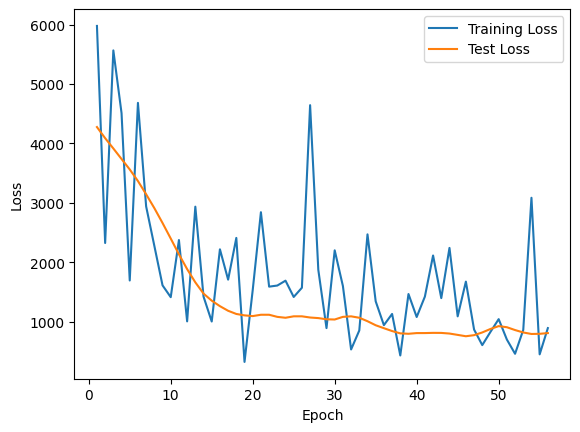

In [13]:
# Plot the training and test losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()